In [1]:
import h5py
import numpy as np
import random

class Data:
  def __init__(self):
    with h5py.File("cell_data.h5", "r") as data:
      self.train_images = [data["/train_image_{}".format(i)][:] for i in range(28)]
      self.train_labels = [data["/train_label_{}".format(i)][:] for i in range(28)]
      self.test_images = [data["/test_image_{}".format(i)][:] for i in range(3)]
      self.test_labels = [data["/test_label_{}".format(i)][:] for i in range(3)]
    
    self.input_resolution = 300
    self.label_resolution = 116

    self.offset = (300 - 116) // 2

  def get_train_image_list_and_label_list(self):
    n = random.randint(0, len(self.train_images) - 1)
    x = random.randint(0, (self.train_images[n].shape)[1] - self.input_resolution - 1)
    y = random.randint(0, (self.train_images[n].shape)[0] - self.input_resolution - 1)
    image = self.train_images[n][y:y + self.input_resolution, x:x + self.input_resolution, :]

    x += self.offset
    y += self.offset
    label = self.train_labels[n][y:y + self.label_resolution, x:x + self.label_resolution]
    
    return [image], [label]

  def get_test_image_list_and_label_list(self):
    coord_list = [[0,0], [0, 116], [0, 232], 
                  [116,0], [116, 116], [116, 232],
                  [219,0], [219, 116], [219, 232]]
    
    image_list = []
    label_list = []
    
    for image_id in range(3):
      for y, x in coord_list:
        image = self.test_images[image_id][y:y + self.input_resolution, x:x + self.input_resolution, :]
        image_list.append(image)
        x += self.offset
        y += self.offset
        label = self.test_labels[image_id][y:y + self.label_resolution, x:x + self.label_resolution]
        label_list.append(label)
    

    return image_list, label_list

In [28]:
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt

import time

In [21]:
def uNet(inputData):
    conlayer1 = lays.conv2d(inputData, 32, [3, 3], stride=1, padding='VALID')
    conlayer1 = lays.conv2d(conlayer1, 32, [3, 3], stride=1, padding='VALID')

    conlayer2 = tf.layers.max_pooling2d(conlayer1, [2, 2], 2, padding='VALID')
    

    conlayer2 = lays.conv2d(conlayer2, 64, [3, 3], stride=1, padding='VALID')
    conlayer2 = lays.conv2d(conlayer2, 64, [3, 3], stride=1, padding='VALID')

    conlayer3 = tf.layers.max_pooling2d(conlayer2, [2, 2], 2)
    

    conlayer3 = lays.conv2d(conlayer3, 128, [3, 3], stride=1, padding='VALID')
    conlayer3 = lays.conv2d(conlayer3, 128, [3, 3], stride=1, padding='VALID')

    conlayer4 = tf.layers.max_pooling2d(conlayer3, [2, 2], 2)
    

    conlayer4 = lays.conv2d(conlayer4, 256, [3, 3], stride=1, padding='VALID')
    conlayer4 = lays.conv2d(conlayer4, 256, [3, 3], stride=1, padding='VALID')

    conlayer5 = tf.layers.max_pooling2d(conlayer4, [2, 2], 2)
    

    conlayer5 = lays.conv2d(conlayer5, 512, [3, 3], stride=1, padding='VALID')
    conlayer5 = lays.conv2d(conlayer5, 512, [3, 3], stride=1, padding='VALID')

    #?
    deconlayer4 = lays.conv2d_transpose(conlayer5, 256, [2, 2], stride=2, padding='VALID')
    deconShape4 = deconlayer4.get_shape().as_list()
    

    # --   x   --
    #   |     |
    #   dA   dB
    #
    #   y
    #
    #   dC   dD
    #   |     |
    # --       --
    conShape4 = conlayer4.get_shape().as_list()
    dA = int(round(0.5 * (conShape4[1]-deconShape4[1])))
    dC = int(round(0.5 * (conShape4[2]-deconShape4[2])))
    dB = conShape4[1]-dA
    dD = conShape4[2]-dC

    conlayer4 = conlayer4[0:conShape4[0], dA:dB, dC:dD, 0:conShape4[3]]
    shape = conlayer4.get_shape()
    conlayer4 = tf.reshape(conlayer4, shape=[-1,shape[1],shape[2], deconShape4[3]])
    deconlayer4 = tf.concat([conlayer4, deconlayer4], 3)


    deconlayer4 = lays.conv2d(deconlayer4, 256, [3, 3], stride=1, padding='VALID')

    deconlayer4 = lays.conv2d(deconlayer4, 256, [3, 3], stride=1, padding='VALID')

    #?
    deconlayer3 = lays.conv2d_transpose(deconlayer4, 128, [2, 2], stride=2, padding='VALID')
    deconShape3 = deconlayer3.get_shape().as_list()
    
    conShape3 = conlayer3.get_shape().as_list()
    dA = int(round(0.5 * (conShape3[1]-deconShape3[1])))
    dC = int(round(0.5 * (conShape3[2]-deconShape3[2])))
    dB = conShape3[1]-dA
    dD = conShape3[2]-dC
    conlayer3 = conlayer3[0:conShape3[0], dA:dB, dC:dD, 0:conShape3[3]]
    shape = conlayer3.get_shape()
    conlayer3 = tf.reshape(conlayer3, shape=[-1,shape[1],shape[2], deconShape3[3]])
    deconlayer3 = tf.concat([conlayer3, deconlayer3], 3)


    deconlayer3 = lays.conv2d(deconlayer3, 128, [3, 3], stride=1, padding='VALID')

    deconlayer3 = lays.conv2d(deconlayer3, 128, [3, 3], stride=1, padding='VALID')

    #?
    deconlayer2 = lays.conv2d_transpose(deconlayer3, 64, [2, 2], stride=2, padding='VALID')
    deconShape2 = deconlayer2.get_shape().as_list()
    
    conShape2 = conlayer2.get_shape().as_list()
    dA = int(round(0.5 * (conShape2[1]-deconShape2[1])))
    dC = int(round(0.5 * (conShape2[2]-deconShape2[2])))
    dB = conShape2[1]-dA
    dD = conShape2[2]-dC
    conlayer2 = conlayer2[0:conShape2[0], dA:dB, dC:dD, 0:conShape2[3]]
    shape = conlayer2.get_shape()
    conlayer2 = tf.reshape(conlayer2, shape=[-1,shape[1],shape[2], deconShape2[3]])
    deconlayer2 = tf.concat([conlayer2, deconlayer2], 3)


    deconlayer2 = lays.conv2d(deconlayer2, 64, [3, 3], stride=1, padding='VALID')

    deconlayer2 = lays.conv2d(deconlayer2, 64, [3, 3], stride=1, padding='VALID')

    #?
    deconlayer1 = lays.conv2d_transpose(deconlayer2, 32, [2, 2], stride=2, padding='VALID')
    deconShape1 = deconlayer1.get_shape().as_list()
    
    conShape1 = conlayer1.get_shape().as_list()
    dA = int(round(0.5 * (conShape1[1]-deconShape1[1])))
    dC = int(round(0.5 * (conShape1[2]-deconShape1[2])))
    dB = conShape1[1]-dA
    dD = conShape1[2]-dC
    conlayer1 = conlayer1[0:conShape1[0], dA:dB, dC:dD, 0:conShape1[3]]
    shape = conlayer1.get_shape()
    conlayer1 = tf.reshape(conlayer1, shape=[-1,shape[1],shape[2], deconShape1[3]])
    deconlayer1 = tf.concat([conlayer1, deconlayer1], 3)


    deconlayer1 = lays.conv2d(deconlayer1, 32, [3, 3], stride=1, padding='VALID')

    deconlayer1 = lays.conv2d(deconlayer1, 32, [3, 3], stride=1, padding='VALID')

    net = lays.conv2d(deconlayer1, 2, [1, 1], stride=1, padding='VALID', activation_fn=None)
    return net

In [41]:
batchSize = 1

x = tf.placeholder(tf.float32, (None, 300, 300, 1))
netOut = uNet(x)

y = tf.placeholder(tf.int32, [None, 116, 116])
#yTensor = tf.reshape(y, shape=[-1, 116, 116, 1])
#yTensor1 = tf.cast(yTensor, tf.int32)
#yTensor2 = tf.one_hot(yTensor1, 2)

#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=yTensor2, logits=netOut))

yResh = tf.reshape(y, [batchSize*116*116])
yHot=tf.one_hot(yResh,2)

netOutResh = tf.reshape(netOut, [batchSize*116*116, 2])

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=yHot, logits=netOutResh))

opt = tf.train.AdamOptimizer(0.0001, 0.95, 0.99).minimize(loss)

In [251]:
def accuray(label, predict):
    correct = np.sum(predict == label[1][0])
    false = np.sum(predict != label[1][0])
    total = predict.shape[0] * predict.shape[1]
    return correct / (total + false)

In [42]:
maxIter = 40000

In [253]:
TrainLoss = []
TrainAcc = []
TestAcc = []

In [44]:
init = tf.global_variables_initializer()

In [45]:
sess = tf.Session()

In [46]:
data = Data()

In [50]:
sess.run(init)

In [254]:
t0 = time.time()
for idx in range(maxIter):
    batch = data.get_train_image_list_and_label_list()
    
    #opt.run(feed_dict={x: batch[0], y: batch[1]})
    _, c = sess.run([opt, loss], feed_dict={x: batch[0], y: batch[1]})
    TrainLoss.append(c)
   
   
    
    if i % 200 == 0:
        reconstImg = sess.run([netOut], feed_dict={x: batch[0], y: batch[1]})[0][0]
        reconstImg=np.argmax(reconstImg, axis=-1)
        bachArr = np.array(batch[1][0])

        TrainLoss.append(c)
        TrainAcc.append(accuray(bachArr, reconstImg))
        
        
            
        #test
        imag, label = data.get_test_image_list_and_label_list()
        testAccuracy=0.0
        for j in range(len(label)):
            reconstImg = sess.run([netOut], feed_dict={x: batch[0], y: batch[1]})[0][0]
            reconstImg=np.argmax(reconstImg, axis=-1)
            bachArr = np.array(batch[1][0])
            testAccuracy += accuray(bachArr, reconstImg)            
        
        testAccuracy = testAccuracy/len(label)
        TestAcc.append(testAccuracy)
        

t1 = time.time()
print('Time: {:.1f}s'.format(t1-t0))

Time: 63.1s


116
116
2
116
116
(116, 116)
116
116
13056
400
13456
0.942263279446


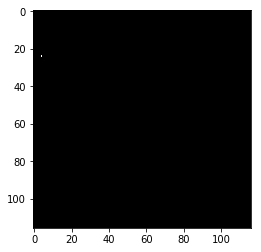

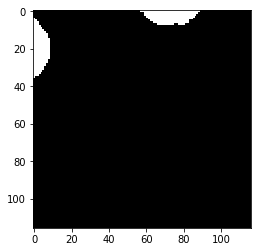

In [228]:
batch = data.get_train_image_list_and_label_list()
reconstImg = sess.run([netOut], feed_dict={x: batch[0], y: batch[1]})[0][0]


#print(len(batch[1][0][0]))
#print(len(reconstImg[0][0]))



#train_accuracy = (np.sum(reconstImg))/(reconstImg.shape[0]-np.sum(reconstImg))
#print(train_accuracy)
#tf.metrics.mean_iou(batch[1], reconstImg, 2)



#print(reconstImg.shape)
#reconstImg=np.argmax(reconstImg, axis=-1)
#print(reconstImg.shape)

#print(np.sum(reconstImg == batch[1]))
print(len(reconstImg))
print(len(reconstImg[0]))
print(len(reconstImg[0][0]))

reconstImg=np.argmax(reconstImg, axis=-1)
print(len(reconstImg))
print(len(reconstImg[0]))

print(reconstImg.shape)
#print(len(batch[1]))
print(len(batch[1][0]))
print(len(batch[1][0][0]))

bachArr = np.array(batch[1][0])
bachArr.shape

correct = np.sum(reconstImg == batch[1][0])
false = np.sum(reconstImg != batch[1][0])
total = reconstImg.shape[0] * reconstImg.shape[1]

print(correct)
print(false)
print(total)

acc = correct / (total + false)
print(acc)
#for ixd in range(116):
plt.figure(0)
plt.imshow(reconstImg, cmap='gray')
plt.figure(1)
plt.imshow(batch[1][0], cmap='gray')
plt.show()
